# SSAM analysis of mouse SSp, imaged by osmFISH
- Author: Jeongbin Park
- Date: 2019-10-13

Set plot parametes / define helper functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

from sklearn import preprocessing
import pickle

In [2]:
## Parameters for post-filtering of cell type maps
filter_method = "local"
filter_params = {
    "block_size": 151,
    "method": "mean",
    "mode": "constant",
    "offset": 0.3
}

In [3]:
def load_tsne(tsne_id):
    with open("zenodo/osmFISH/tsne/%s.pkl"%tsne_id, "rb") as f:
        ds.tsne = pickle.load(f)

In [4]:
def shorten_labels(lbls):
    l = []
    for lbl in lbls:
        lbl = lbl[0].capitalize() + lbl[1:]
        l.append(lbl
                 .replace("Oligodendrocyte Precursor cells", "OPC")
                 .replace("Oligodendrocyte", "OD")
                 .replace("Vascular Smooth Muscle", "VSM")
                 .replace("Astrocyte", "Astro.")
                 .replace("Perivascular Macrophages", "PVM")
                 .replace("Pyramidal", "Py.")
                 .replace("Inhibitory", "Inhib.")
                )
    return l

In [5]:
width_cutoff = 1640 # um

## Load data

Load mRNA spot locations

In [6]:
import numpy as np
import h5py
from collections import OrderedDict

pixel_per_um = 15.3846 # from BioRxiv paper
um_per_pixel = 1.0 / pixel_per_um
f = h5py.File("zenodo/osmFISH/raw_data/mRNA_coords_raw_counting.hdf5", 'r')
keys = list(f.keys())

pos_dic = OrderedDict()
genes = []

# Exclude bad quality data, according to the supplementary material of osmFISH paper
blacklists = ['Cnr1_Hybridization4', 'Plp1_Hybridization4', 'Vtn_Hybridization4',
              'Klk6_Hybridization5', 'Lum_Hybridization9', 'Tbr1_Hybridization11']

for k in keys:
    if k in blacklists:
        continue
    gene = k.split("_")[0]
    
    # Correct wrong gene labels
    if gene == 'Tmem6':
        gene = 'Tmem2'
    elif gene == 'Kcnip':
        gene = 'Kcnip2'
    
    points = np.array(f[k]) * um_per_pixel
    if gene in pos_dic:
        pos_dic[gene] = np.vstack((pos_dic[gene], points))
    else:
        pos_dic[gene] = points
        genes.append(gene)
genes = sorted(genes)

## SSAM analysis
### Run KDE and select representative vectors

Initilize SSAM and run KDE

In [7]:
import ssam

In [8]:
width, height = 2080, 3380 # um

In [9]:
all_genes = list(pos_dic.keys())
mrna_loci = [pos_dic[gene] for gene in all_genes]

ds = ssam.SSAMDataset(all_genes, mrna_loci, width, height)
analysis = ssam.SSAMAnalysis(ds, ncores=10,
                             save_dir="zenodo/osmFISH/kde",
                             verbose=True)

analysis.run_kde(bandwidth=2.5, use_mmap=False)

In [10]:
# Cut off the excluded region from the image
# (the region was used for testing stripping efficiency) 

ds.vf = ds.vf[:width_cutoff, ...]
ds.shape = (1640, ds.shape[1], ds.shape[2], )

Select local maxima of gene expression in the vector field

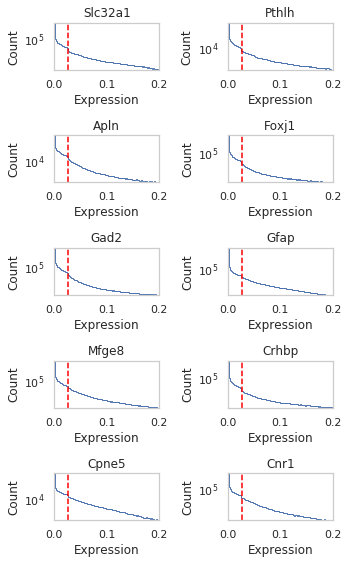

In [11]:
exp_thres = 0.027
viewport = 0.2
gindices = np.arange(len(ds.genes))
np.random.shuffle(gindices)
plt.figure(figsize=[5, 8])
for i, gidx in enumerate(gindices[:10], start=1):
    ax = plt.subplot(5, 2, i)
    n, bins, patches = ax.hist(ds.vf[..., gidx][np.logical_and(ds.vf[..., gidx] > 0, ds.vf[..., gidx] < viewport)], bins=100, log=True, histtype=u'step')
    ax.set_xlim([0, viewport])
    ax.set_ylim([n[0], n[-1]])
    ax.axvline(exp_thres, c='red', ls='--')
    ax.set_title(ds.genes[gidx])
    ax.set_xlabel("Expression")
    ax.set_ylabel("Count")
plt.tight_layout()
pass

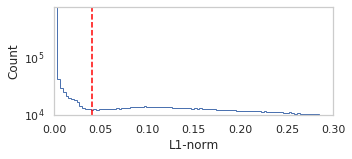

In [12]:
gidx = 0
norm_thres = 0.04
plt.figure(figsize=[5, 2])
#plt.hist(ds.vf[..., gidx][ds.vf[..., gidx] > 0], bins=100, log=True)
n, _, _ = plt.hist(ds.vf_norm[np.logical_and(ds.vf_norm > 0, ds.vf_norm < 0.3)], bins=100, log=True, histtype='step')
ax = plt.gca()
ax.axvline(norm_thres, c='red', ls='--')
ax.set_xlabel("L1-norm")
ax.set_ylabel("Count")

plt.xlim([0, 0.3])
plt.ylim([n[0], n[-1]])
pass

In [13]:
analysis.find_localmax(search_size=3, min_norm=norm_thres, min_expression=exp_thres)

Found 11469 local max vectors.


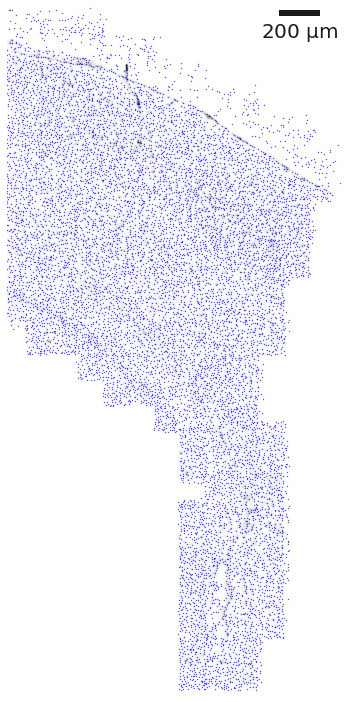

In [14]:
plt.figure(figsize=[5, 10.3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0], ds.local_maxs[1], c="blue", s=0.1)

from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([ds.vf.shape[0], 0])
plt.ylim([ds.vf.shape[1], 0])
plt.show()

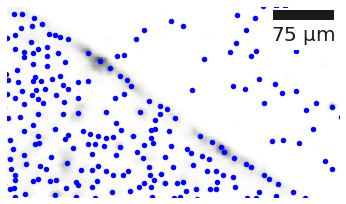

In [15]:
plt.figure(figsize=[5, 3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0], ds.local_maxs[1], c="blue", s=20)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20}, height_fraction=0.05)
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([760, 355])
plt.ylim([707, 475])
plt.show()

Remove spurious local maxima based on KNN density

In [16]:
from sklearn.neighbors import KDTree
X = np.array([ds.local_maxs[0], ds.local_maxs[1]]).T
kdt = KDTree(X, leaf_size=30, metric='euclidean')
rho = 100 / (np.pi * kdt.query(X, k=100)[0][:, 99] ** 2)

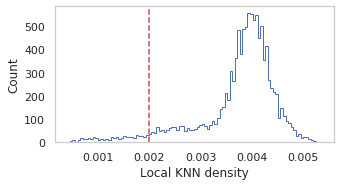

In [17]:
threshold = 0.002

plt.figure(figsize=[5, 2.5])
plt.hist(rho, bins=100, histtype='step')
plt.axvline(x=threshold, color='r', linestyle='--')

ax = plt.gca()
ax.set_xlabel("Local KNN density")
ax.set_ylabel("Count")
pass

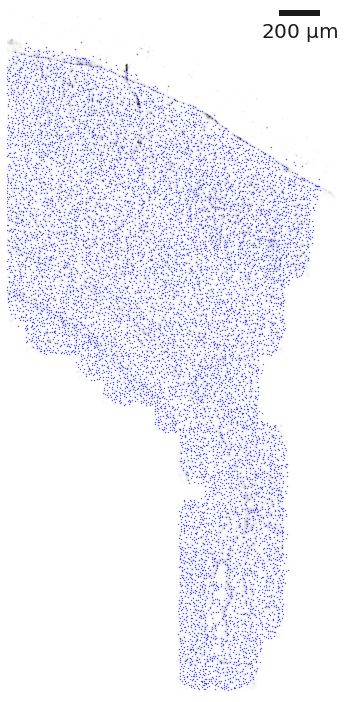

In [18]:
mask = rho > threshold

plt.figure(figsize=[5, 10.3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0][mask], ds.local_maxs[1][mask], c="blue", s=0.1)

from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([ds.vf.shape[0], 0])
plt.ylim([ds.vf.shape[1], 0])
plt.show()

In [ ]:
plt.figure(figsize=[5, 3])
ds.plot_l1norm(cmap="Greys", rotate=1)
plt.scatter(ds.local_maxs[0][mask], ds.local_maxs[1][mask], c="blue", s=20)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20}, height_fraction=0.05)
plt.gca().add_artist(scalebar)
plt.axis('off')

plt.tight_layout()
plt.xlim([760, 355])
plt.ylim([707, 475])
plt.show()

Apply mask

In [20]:
ds.local_maxs = tuple(ds.local_maxs[i][mask] for i in range(3))

Normalize local maxima vectors and vector field

In [22]:
# this requires local R installation with packages 'sctransform' and 'feather'
analysis.normalize_vectors_sctransform()

## SSAM guided mode: using MERFISH segmentation-based centroids and scRNA-seq data (Marques *et al*. and *et al*.)

### 1) SSAM guided by segmentation-based cluster centroids

Load osmFISH segementation-based expression data

In [23]:
# Load osmFISH data
import loompy
osmfish_loom = loompy.connect("zenodo/osmFISH/raw_data/osmFISH_SScortex_mouse_all_cells.loom")

In [24]:
from sklearn.preprocessing import normalize, scale
from scipy.stats import median_test

osmfish_genes = list(osmfish_loom.row_attrs['Gene'])
osmfish_gene_indices = [osmfish_genes.index(gene) for gene in ds.genes]
osmfish_clusters = osmfish_loom.col_attrs['ClusterName']
osmfish_data = osmfish_loom[:,:].T[:, osmfish_gene_indices][osmfish_clusters != "Excluded", :]
osmfish_clusters = osmfish_clusters[osmfish_clusters != "Excluded"]
osmfish_uniq_labels = sorted(set(osmfish_clusters) - set(['Excluded']))

In [25]:
osmfish_data_normalized = np.array(ssam.run_sctransform(osmfish_data)[0])

In [26]:
osmfish_centroids = np.zeros([len(osmfish_uniq_labels), len(osmfish_genes)])
for cl_idx, osmfish_cluster in enumerate(osmfish_uniq_labels):
    osmfish_centroids[cl_idx, :] = np.mean(osmfish_data_normalized[osmfish_clusters == osmfish_cluster, :], axis=0)

In [27]:
osmfish_ref_colors = {
    "Inhibitory CP": "#9b067d",
    "Inhibitory Crhbp": "#9805cc",
    "Inhibitory Cnr1": "#ca4479",
    "Inhibitory IC": "#ff49b0",
    "Inhibitory Kcnip2": "#af7efe",
    "Inhibitory Pthlh": "#4e14a6",
    "Inhibitory Vip": "#7759a4",
    "Pyramidal Cpne5": "#3e4198",
    "Pyramidal L2-3": "#0ab4e4",
    "Pyramidal L2-3 L5": "#1e6a87",
    "Pyramidal Kcnip2": "#6787d6",
    "Pyramidal L3-4": "#004dba",
    "pyramidal L4": "#78edff",
    "Pyramidal L5": "#0a9fb4",
    "Pyramidal L6": "#027fd0",
    "Hippocampus": "#004b71",
    "Astrocyte Gfap": "#de4726",
    "Astrocyte Mfge8": "#f69149",
    "Oligodendrocyte Precursor cells": "#b3ee3d",
    "Oligodendrocyte COP": "#5dd73d",
    "Oligodendrocyte NF": "#64a44e",
    "Oligodendrocyte MF": "#2f7449",
    "Oligodendrocyte Mature": "#285528",
    "Perivascular Macrophages": "#762a14",
    "Microglia": "#a7623d",
    "C. Plexus": "#21b183",
    "Ependymal": "#fadf0b",
    "Pericytes": "#f8c495",
    "Endothelial": "#f81919",
    "Endothelial 1": "#f05556",
    "Vascular Smooth Muscle": "#aec470",
}
osmfish_colors = [osmfish_ref_colors[cl] for cl in osmfish_uniq_labels]

In [28]:
analysis.map_celltypes(osmfish_centroids)
#analysis.filter_celltypemaps(min_norm=0.5, min_r=0.6)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6)

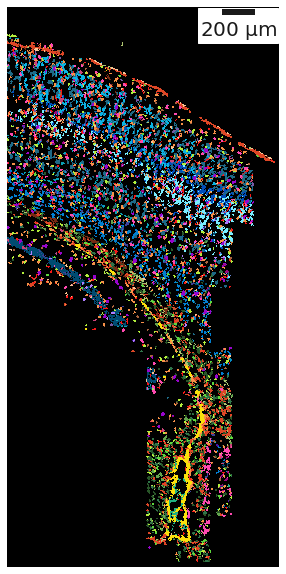

In [29]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(colors=osmfish_colors, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)
pass

### 2) SSAM guided by scRNA-seq cluster centroids

In [30]:
# Load scRNAseq data
scrna_loom = loompy.connect("zenodo/osmFISH/raw_data/single-cell_cortex_oligo.loom")
scrna_genes_idx = [list(scrna_loom.row_attrs['genes']).index(g) for g in ds.genes]
scrna_labels = np.array(scrna_loom.col_attrs['labels'])
scrna_matrix = scrna_loom[:, :].T
scrna_matrix = scrna_matrix[:, scrna_genes_idx] + 0.01 # Add a small nudge for geomean calculation during normalization

In [31]:
# Normalize it with sctransform
scrna_matrix_normalized = np.array(ssam.run_sctransform(scrna_matrix)[0])

In [32]:
scrna_uniq_labels = np.unique(scrna_labels) # np.unique is sorted
scrna_centroids = np.zeros([len(scrna_uniq_labels), len(ds.genes)])
for cidx, cl in enumerate(scrna_uniq_labels):
    scrna_centroids[cidx, :] = np.mean(scrna_matrix_normalized[scrna_labels == cl, :], axis=0)

In [33]:
analysis.map_celltypes(scrna_centroids)
#analysis.filter_celltypemaps(min_norm=0.5, min_r=0.4)
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.4)

In [34]:
# Define color of scRNAseq data based on colors of segmentation-based data
from matplotlib import colors

osm_scrna_corrs = np.zeros((len(scrna_centroids), len(osmfish_centroids)))
for i, scrna_centroid in enumerate(scrna_centroids):
    for j, osmfish_centroid in enumerate(osmfish_centroids):
        osm_scrna_corrs[i, j] = ssam.utils.corr(scrna_centroid, osmfish_centroid)

osm_scrna_max_corr = np.max(osm_scrna_corrs, axis=1)
osm_scrna_max_corr_idx = np.argmax(osm_scrna_corrs, axis=1)
osm_scrna_rowheaders_corr = np.array(osmfish_uniq_labels)[osm_scrna_max_corr_idx]

# Beware that this can make some clusters have the same color!
scrna_colors_dic = {}
for scrna_cl, osm_cl in zip(scrna_uniq_labels, osm_scrna_rowheaders_corr):
    col = osmfish_ref_colors.get(osm_cl, 'black')
    if col != 'black':
        while col in scrna_colors_dic:
            r, g, b = colors.to_rgb(col)
            r -= 0.05; r = 0.0 if r < 0.0 else r
            g -= 0.05; g = 0.0 if g < 0.0 else g
            b -= 0.05; b = 0.0 if b < 0.0 else b
            col = colors.to_hex([r,g,b])
    scrna_colors_dic[scrna_cl] = col
scrna_colors = [scrna_colors_dic[cl] for cl in scrna_uniq_labels]

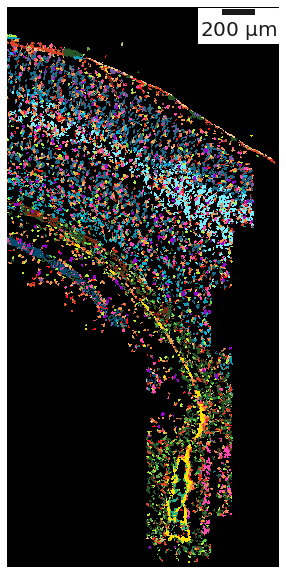

In [35]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(colors=scrna_colors, rotate=1, set_alpha=False)
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)

## SSAM *de novo* mode

In [36]:
analysis.cluster_vectors(pca_dims=33, resolution=0.15, max_correlation=1.0, metric="correlation", centroid_correction_threshold=0.6)

Found 66 clusters


In [37]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, fill_blobs=True, min_blob_area=50)

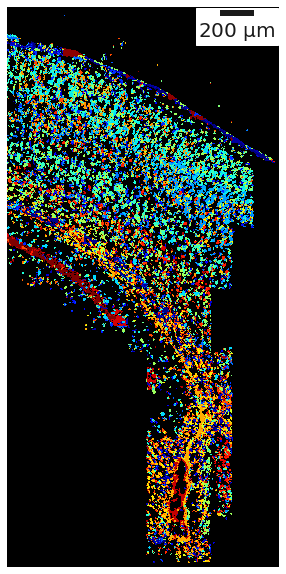

In [38]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(rotate=1, set_alpha=False)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)

In [39]:
load_tsne('excluded')

(-111.40979437184954, 88.78233770681048, -98.303474220407, 92.76610544599293)

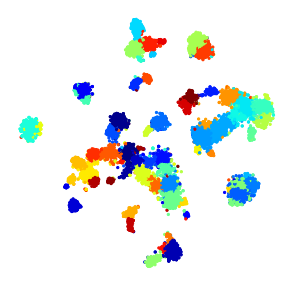

In [40]:
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False)
plt.axis('off')

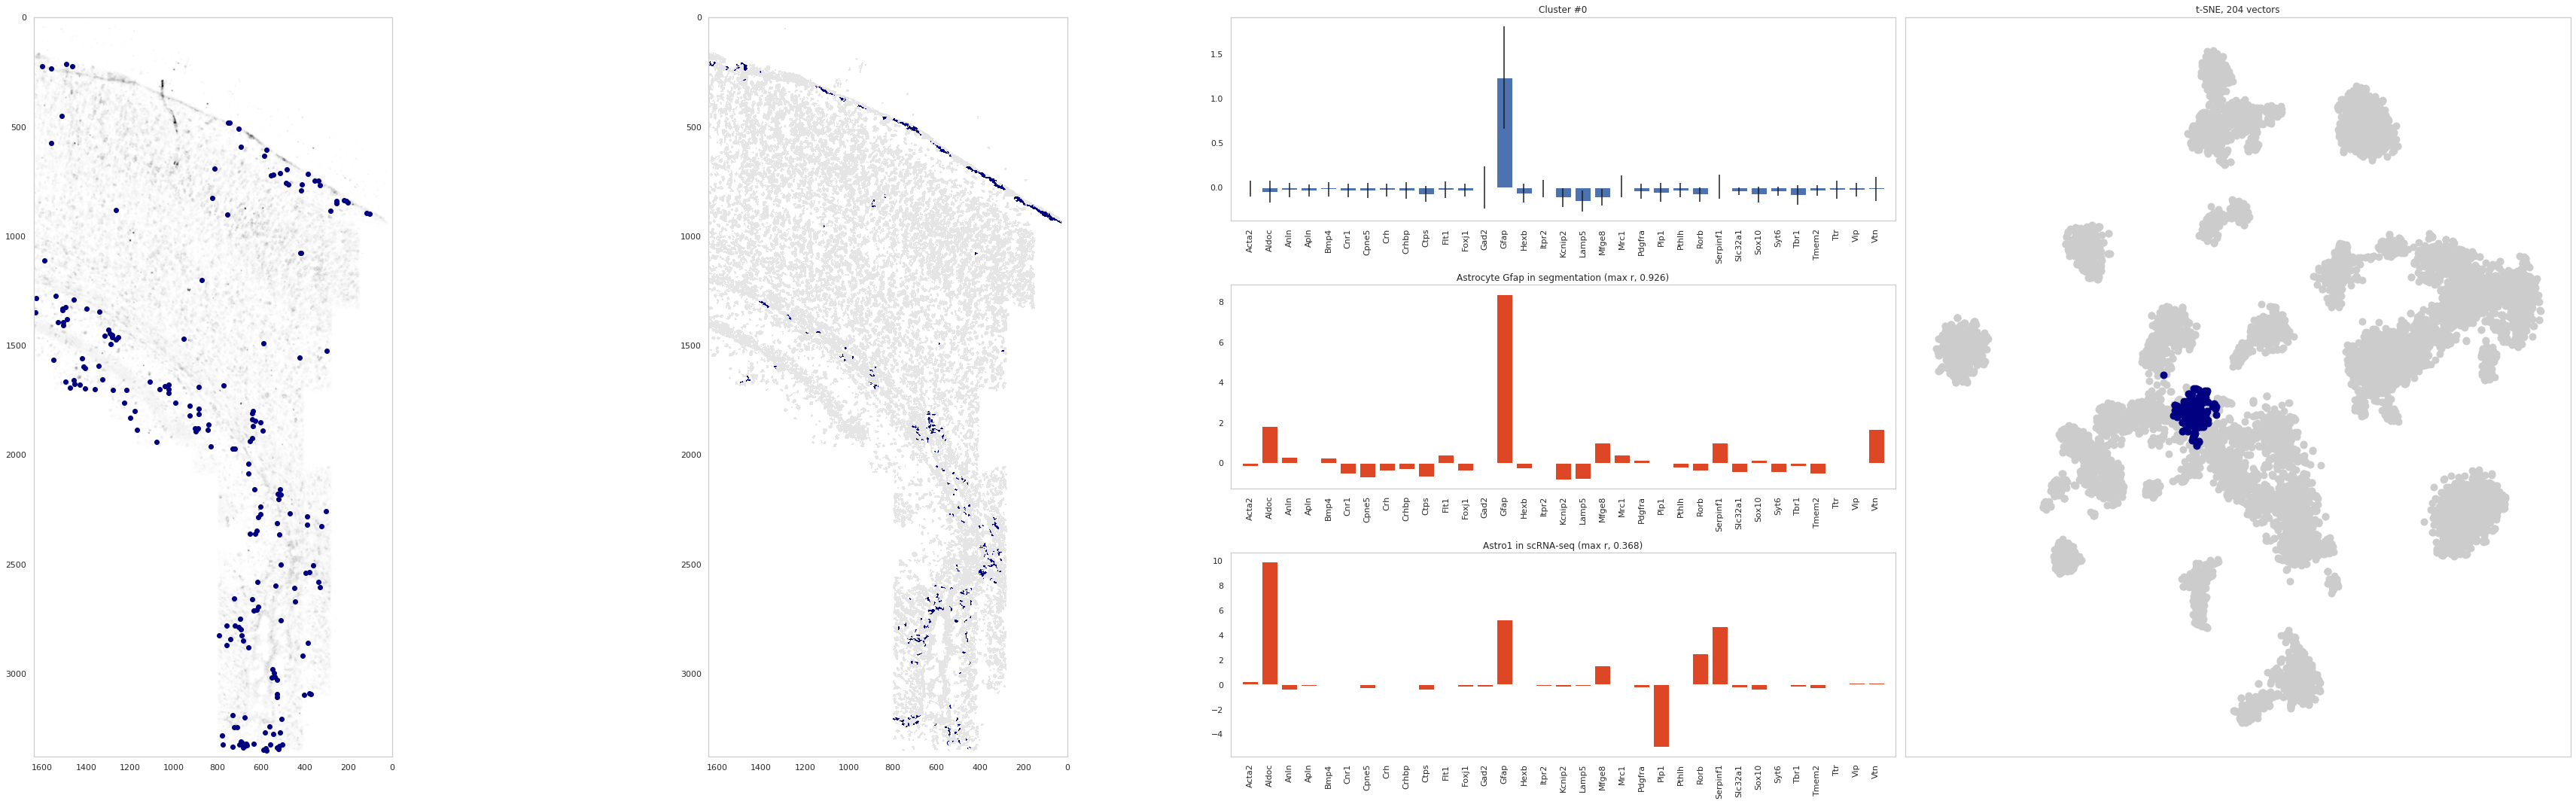

In [41]:
from scipy.stats import pearsonr, spearmanr

for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx, known_signatures=[
        ("segmentation", osmfish_uniq_labels, osmfish_centroids, osmfish_colors),
        ("scRNA-seq", scrna_uniq_labels, scrna_centroids, scrna_colors),
    ], correlation_methods=[
        ("r", pearsonr),
    ])
    plt.tight_layout()
    plt.savefig('diagplots_osmFISH/diagplot_centroid_%d.png'%idx)
    #plt.close()
    break

In [42]:
denovo_labels = [
    "Astrocyte Gfap",
    "Perivascular Macrophages",
    "N/A",
    "Endothelial",
    "Astrocyte Gfap (Aldoc)",
    "Oligodendrocyte COP",
    "Oligodendrocyte NF",
    "Microglia",
    "Endothelial 1",
    "Astrocyte Aldoc",
    
    "Pyramidal Cpne5",
    "Inhibitory Vip",
    "Astrocyte Gfap (Aldoc)",
    "Vascular Smooth Muscle",
    "N/A",
    "Pyramidal L5 (Tbr1)",
    "N/A",
    "Astrocyte Mfge8",
    "pyramidal L4",
    "Pyramidal L3-4",
    
    "N/A",
    "Inhibitory Pthlh",
    "Inhibitory Crhbp",
    "Pyramidal L2-3 L5",
    "Pyramidal L2-3 L5 (Tbr1)",
    "Oligodendrocyte Precursor cells",
    "N/A (Aldoc and Inhib neuron mixture?)",
    "Pyramidal L2-3 L5",
    "Microglia",
    "Astrocyte Mfge8",
    
    "Pyramidal L2-3 L5",
    "Astrocyte Mfge8",
    "N/A",
    "N/A",
    "Pericytes",
    "Inhibitory Rest",
    "Pyramidal L6",
    "Pyramidal L2-3 L5",
    "Microglia",
    "Astrocyte Gfap (Tbr1)",
    
    "Astrocyte Gfap (Aldoc, Mfge8)",
    "Oligodendrocyte Precursor cells",
    "pyramidal L4",
    "Oligodendrocyte Mature",
    "N/A",
    "Oligodendrocyte NF",
    "Oligodendrocyte MF",
    "Ependymal",
    "Pyramidal L3-4",
    "Pyramidal L2-3",
    
    "N/A",
    "Endothelial (Endothelial and Mfge8 mixture?)",
    "Astrocyte Mfge8",
    "Astrocyte Gfap",
    "Inhibitory Cnr1",
    "Pyramidal L6",
    "Oligodendrocyte Mature",
    "Inhibitory Kcnip2",
    "Endothelial",
    "Inhibitory Kcnip2",
    
    "Hippocampus",
    "C. Plexus",
    "Oligodendrocyte Mature",
    "Astrocyte Gfap (Astrocyte and Kcnip2 mixture?)",
    "N/A (Artifact)",
    "Hippocampus",
]

In [43]:
denovo_labels_final = []
exclude_indices = []
merge_indices = []
import re

p = re.compile(r' \(.*\)')

denovo_labels_short = [p.sub("", cl) for cl in denovo_labels]
for idx, cl in enumerate(denovo_labels_short):
    if cl == 'N/A':
        exclude_indices.append(idx)
        continue
    if cl in denovo_labels_final:
        continue
    denovo_labels_final.append(cl)
for cl in np.unique(denovo_labels_short):
    if cl == 'N/A':
        continue
    mask = [cl == e for e in denovo_labels_short]
    if np.sum(mask) > 1:
        merge_indices.append(np.where(mask)[0])

(-111.40979437184954, 88.78233770681048, -98.303474220407, 92.76610544599293)

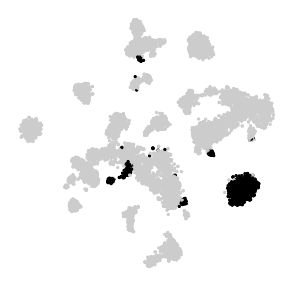

In [44]:
cmap = plt.get_cmap('jet')
jet_colors = cmap(np.array(list(range(len(ds.centroids)))) / (len(ds.centroids) - 1))
tsne_colors = np.zeros_like(jet_colors)
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
tsne_colors[exclude_indices] = [0, 0, 0, 1] #jet_colors[exclude_indices]
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.gca().axis('off')

(-112.29564684617479, 89.66819018113573, -99.17135271252965, 93.63398393811565)

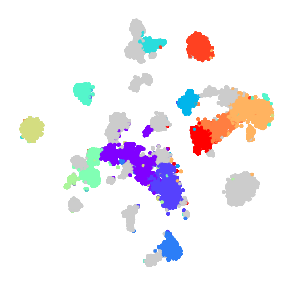

In [45]:
cmap = plt.get_cmap('rainbow')
jet_colors = cmap(np.array(list(range(len(merge_indices)))) / (len(merge_indices) - 1))
plt.figure(figsize=[5, 5])
tsne_colors = np.zeros([len(ds.centroids), 4])
tsne_colors[..., :] = [0.8, 0.8, 0.8, 1]
for idx, mi in enumerate(merge_indices):
    tsne_colors[mi] = jet_colors[idx]
    ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=tsne_colors)
plt.gca().axis('off')

In [46]:
analysis.exclude_and_merge_clusters(exclude_indices, merge_indices, centroid_correction_threshold=0.6)

In [47]:
import matplotlib
denovo_celltype_colors = []
for cl in denovo_labels_final:
    if cl == "Astrocyte Aldoc":
        col = "#e87038"
    elif cl == "Inhibitory Rest":
        col = osmfish_ref_colors.get("Inhibitory IC")
    else:
        col = osmfish_ref_colors.get(cl)
    denovo_celltype_colors.append(col)

In [48]:
heatmap_clusters_ordered = [
    'Inhibitory Kcnip2',
    'Inhibitory Crhbp',
    'Inhibitory Cnr1',
    'Inhibitory Rest',
    'Inhibitory Pthlh',
    'Inhibitory Vip',
    'Pyramidal Cpne5',
    'Pyramidal L2-3',
    'Pyramidal L2-3 L5',
    'Pyramidal L3-4',
    'pyramidal L4',
    'Pyramidal L5',
    'Pyramidal L6',
    'Hippocampus',
    'Astrocyte Aldoc',
    'Astrocyte Gfap',
    'Astrocyte Mfge8',
    'Oligodendrocyte Precursor cells',
    'Oligodendrocyte COP',
    'Oligodendrocyte NF',
    'Oligodendrocyte MF',
    'Oligodendrocyte Mature',
    'Perivascular Macrophages',
    'Microglia',
    'C. Plexus',
    'Ependymal',
    'Pericytes',
    'Endothelial',
    'Endothelial 1',
    'Vascular Smooth Muscle',
]
heatmap_genes_ordered = [
    'Gad2',
    'Slc32a1',
    'Crhbp',
    'Cnr1',
    'Vip',
    'Cpne5',
    'Pthlh',
    'Crh',
    'Tbr1',
    'Lamp5',
    'Rorb',
    'Syt6',
    'Kcnip2',
    'Aldoc',
    'Gfap',
    'Serpinf1',
    'Mfge8',
    'Sox10',
    'Plp1',
    'Pdgfra',
    'Bmp4',
    'Itpr2',
    'Tmem2',
    'Ctps',
    'Anln',
    'Mrc1',
    'Hexb',
    'Ttr',
    'Foxj1',
    'Vtn',
    'Flt1',
    'Apln',
    'Acta2'
]
heatmap_clusters_index = [denovo_labels_final.index(cl) for cl in heatmap_clusters_ordered]
heatmap_genes_index = [ds.genes.index(g) for g in heatmap_genes_ordered]

In [49]:
from matplotlib.colors import to_rgba

heatmap_vectors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), len(ds.genes)], dtype=float)
col_colors = np.zeros([np.sum(ds.filtered_cluster_labels != -1), 4])
acc_idx = 0
for cl_idx in heatmap_clusters_index:
    cl_vecs = ds.normalized_vectors[ds.filtered_cluster_labels == cl_idx]
    col = denovo_celltype_colors[cl_idx]
    heatmap_vectors[acc_idx:acc_idx+cl_vecs.shape[0], :] = cl_vecs
    col_colors[acc_idx:acc_idx+cl_vecs.shape[0]] = to_rgba(col)
    acc_idx += cl_vecs.shape[0]
heatmap_vectors = heatmap_vectors[:, heatmap_genes_index]

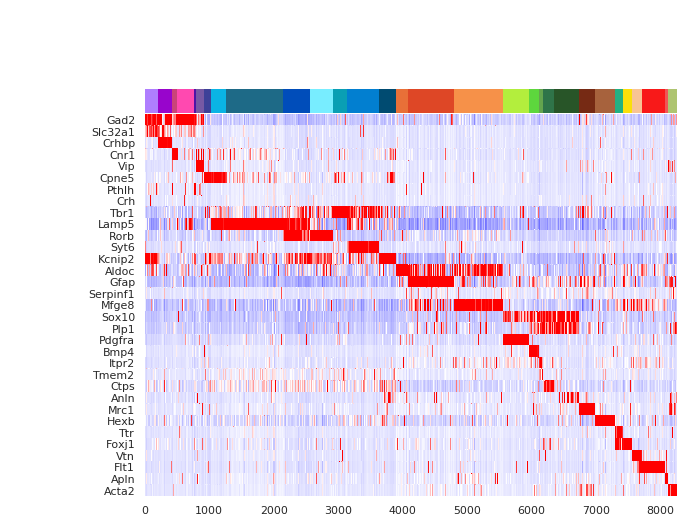

In [50]:
import seaborn as sns
gene_exp_heatmap = heatmap_vectors.T
gene_exp_heatmap = preprocessing.scale(gene_exp_heatmap)
g = sns.clustermap(gene_exp_heatmap, figsize=[12, 9], yticklabels=heatmap_genes_ordered,
                 cmap='bwr', row_cluster=False, col_cluster=False,
                 col_colors=col_colors, xticklabels = 1000, vmin=-2.5, vmax=2.5)
g.cax.set_visible(False)
g.ax_heatmap.tick_params(labelright=False, labelleft=True, right=False)

In [51]:
load_tsne("merged")

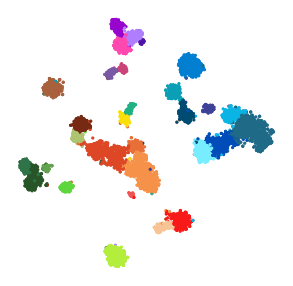

In [52]:
import matplotlib.patheffects as PathEffects
plt.figure(figsize=[5, 5])
ds.plot_tsne(pca_dims=33, metric="correlation", s=5, run_tsne=False, colors=denovo_celltype_colors)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.gca().axis('off')
pass

In [127]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=filter_method, filter_params=filter_params, min_r=0.6, fill_blobs=True, min_blob_area=50)

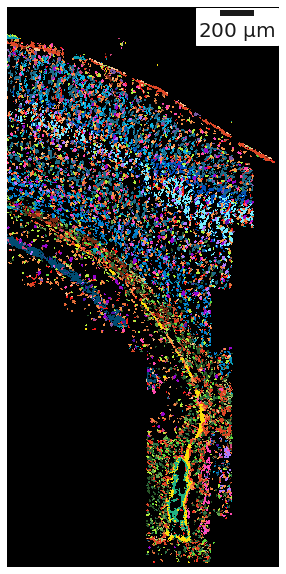

In [129]:
plt.figure(figsize=[5, 10.3])
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False)

scalebar = ScaleBar(1, 'um', pad=0.2, font_properties={"size": 20})
plt.gca().add_artist(scalebar)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)

plt.show()

In [80]:
osmfish_uniq_labels_ordered = [
    'Inhibitory CP',
    'Inhibitory Crhbp',
    'Inhibitory Cnr1',
    'Inhibitory IC',
    'Inhibitory Kcnip2',
    'Inhibitory Pthlh',
    'Inhibitory Vip',
    'Pyramidal Cpne5',
    'Pyramidal L2-3',
    'Pyramidal L2-3 L5',
    'Pyramidal L3-4',
    'pyramidal L4',
    'Pyramidal Kcnip2',
    'Pyramidal L5',
    'Pyramidal L6',
    'Hippocampus',
    'Astrocyte Gfap',
    'Astrocyte Mfge8',
    'Oligodendrocyte Precursor cells',
    'Oligodendrocyte COP',
    'Oligodendrocyte NF',
    'Oligodendrocyte MF',
    'Oligodendrocyte Mature',
    'Perivascular Macrophages',
    'Microglia',
    'C. Plexus',
    'Ependymal',
    'Pericytes',
    'Endothelial',
    'Endothelial 1',
    'Vascular Smooth Muscle',
]
scrna_uniq_labels_ordered = [
    'Int1',
    'Int2',
    'Int3',
    'Int4',
    'Int5',
    'Int6',
    'Int7',
    'Int8',
    'Int9',
    'Int10',
    'Int11',
    'Int12',
    'Int13',
    'Int14',
    'Int15',
    'Int16',
    'CA1PyrInt',
    'PyrL23',
    'PyrL4',
    'PyrL5',
    'PyrL5a',
    'PyrL6',
    'PyrL6b',
    'SubPyr',
    'PyrDL',
    'CA1Pyr1',
    'CA1Pyr2',
    'CA2Pyr2',
    'ClauPyr',
    'Astro1',
    'Astro2',
    'OPC',
    'COP',
    'NFOL1',
    'NFOL2',
    'MFOL1',
    'MFOL2',
    'MOL1',
    'MOL2',
    'MOL3',
    'MOL4',
    'MOL5',
    'MOL6',
    'Pvm1',
    'Pvm2',
    'Mgl1',
    'Mgl2',
    'Choroid',
    'Epend',
    'Peric',
    'Vend1',
    'Vend2',
    'Vsmc',
    'Vlmc',
]

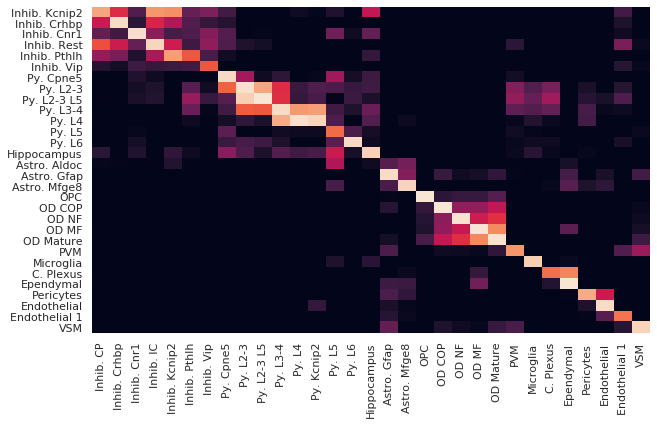

In [81]:
osmfish_uniq_labels_index = [osmfish_uniq_labels.index(i) for i in osmfish_uniq_labels_ordered]

dcs = np.array(ds.centroids)[heatmap_clusters_index]
ocs = osmfish_centroids[osmfish_uniq_labels_index]

centroids_corr = np.zeros([len(osmfish_centroids), len(ds.centroids)])
for i, oc in enumerate(ocs):
    for j, dc in enumerate(dcs):
        centroids_corr[i, j] = ssam.utils.corr(oc, dc)

plt.figure(figsize=[10, 6])
sns.heatmap(centroids_corr.T,
            yticklabels=shorten_labels(heatmap_clusters_ordered),
            xticklabels=shorten_labels(osmfish_uniq_labels_ordered), cbar=False, vmin=0, vmax=1)
#plt.ylabel("SSAM clusters")
#plt.xlabel("osmFISH clusters")

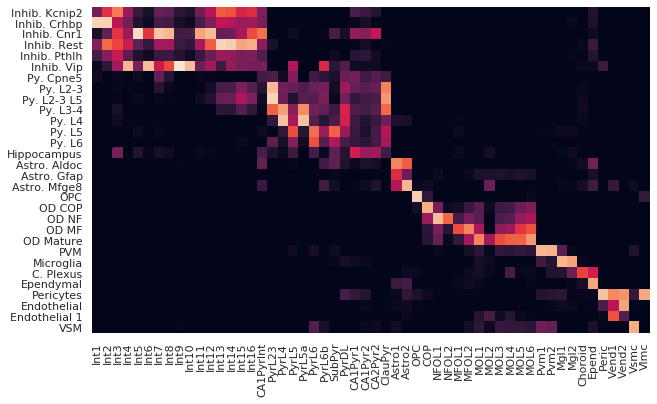

In [82]:
scrna_uniq_labels_stripped = ["Vlmc" if cl == "PPR" else (cl[2:] if cl[:2] == "S1" else cl) for cl in scrna_uniq_labels]
scrna_uniq_labels_index = [scrna_uniq_labels_stripped.index(i) for i in scrna_uniq_labels_ordered]

dcs = np.array(ds.centroids)[heatmap_clusters_index]
scs = scrna_centroids[scrna_uniq_labels_index]

centroids_corr = np.zeros([len(scrna_centroids), len(ds.centroids)])
for i, sc in enumerate(scs):
    for j, dc in enumerate(dcs):
        centroids_corr[i, j] = ssam.utils.corr(sc, dc)

plt.figure(figsize=[10, 6])
sns.heatmap(centroids_corr.T,
            yticklabels=shorten_labels(heatmap_clusters_ordered),
            xticklabels=shorten_labels(scrna_uniq_labels_ordered), cbar=False, vmin=0, vmax=1)
#plt.ylabel("SSAM clusters")
#plt.xlabel("scRNA clusters")

In [83]:
analysis.bin_celltypemaps(step=10, radius=100)

In [84]:
analysis.find_domains(n_clusters=15, merge_remote=False, merge_thres=0.6, norm_thres=4500)

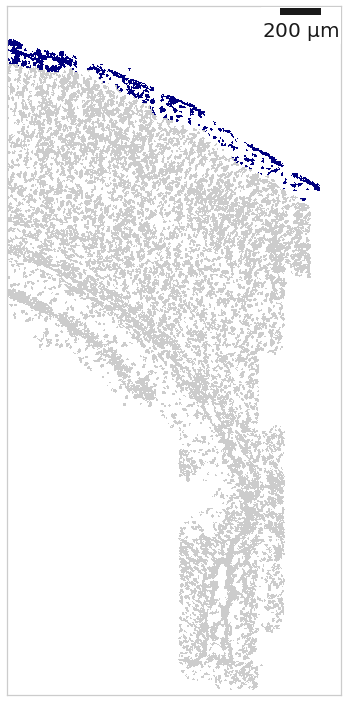

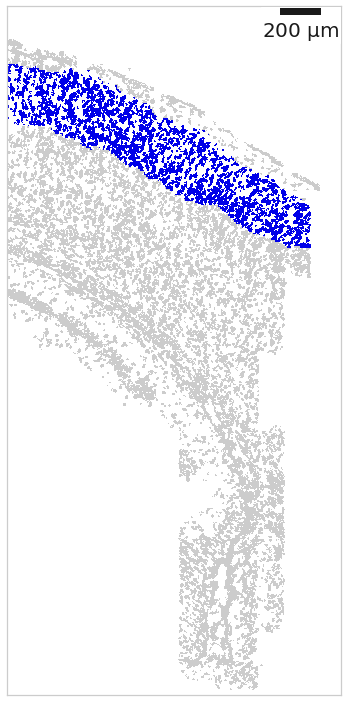

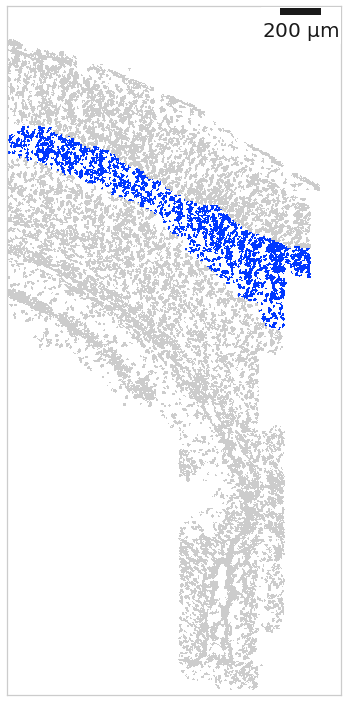

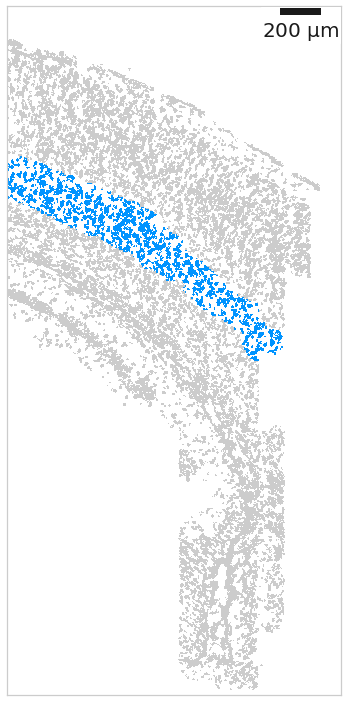

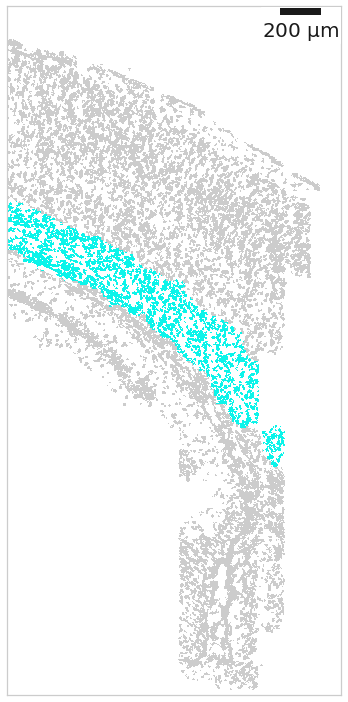

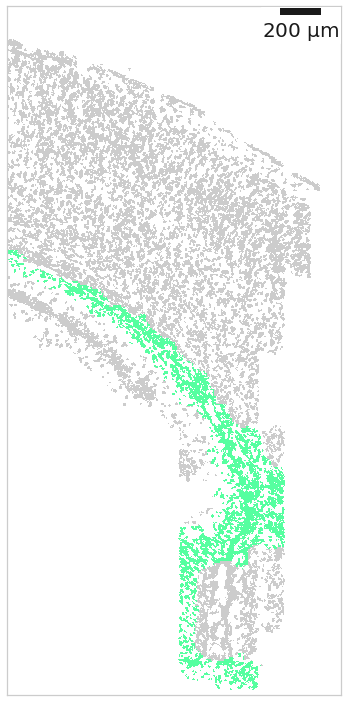

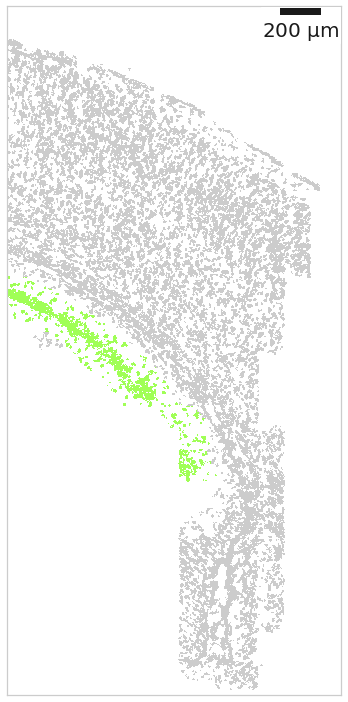

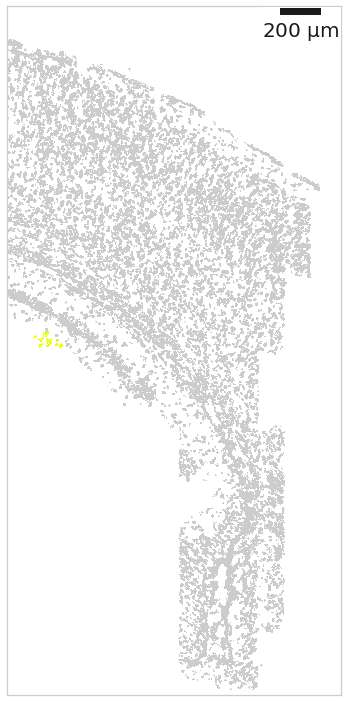

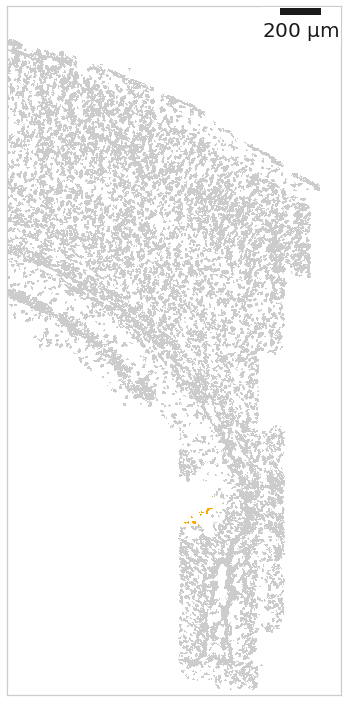

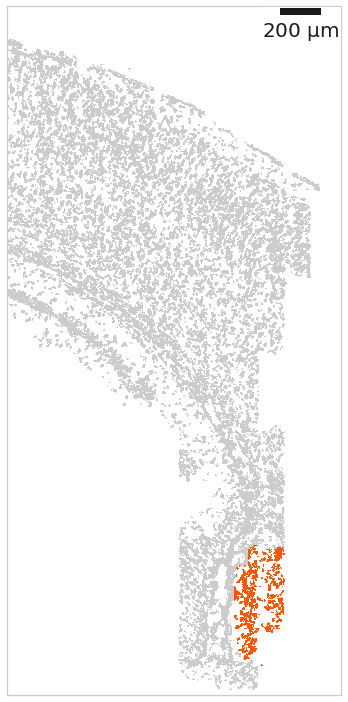

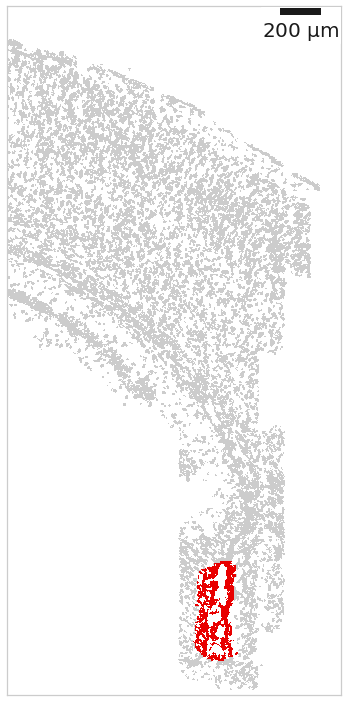

In [134]:
# Check found domains
from matplotlib.colors import ListedColormap
cmap_jet = plt.get_cmap('jet')
num_domains = np.max(ds.inferred_domains_cells) + 1
for domain_idx in range(num_domains):
    plt.figure(figsize=[5, 10.3])
    cmap = ListedColormap([cmap_jet(lbl_idx / num_domains) if domain_idx == lbl_idx else "#cccccc" for lbl_idx in range(num_domains)])
    ds.plot_domains(rotate=1, cmap=cmap)
    scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
    plt.gca().add_artist(scalebar)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.tight_layout()

In [135]:
domain_colors = {
    'Pia+Layer 1': '#D44218',
    'Layer 2/3': '#85D7E4',
    'Layer 4': '#F6B813',
    'Layer 5': '#C6271B',
    'Layer 6': '#4987B9',
    'White matter': '#58BC06',
    'Hippocampus': '#104368',
    'Ventricle': '#F4D527',
    'IC CP': '#9C2387',
}

In [136]:
excluded_domain_indices = []
merged_domain_indices = [[5, 7, 8], ]

In [137]:
analysis.exclude_and_merge_domains(excluded_domain_indices, merged_domain_indices)

In [138]:
domain_labels = [
    'Pia+Layer 1',
    'Layer 2/3',
    'Layer 4',
    'Layer 5',
    'Layer 6',
    'White matter',
    'Hippocampus',
    'IC CP',
    'Ventricle',
]

(1639.5, -0.5, 3379.5, -0.5)

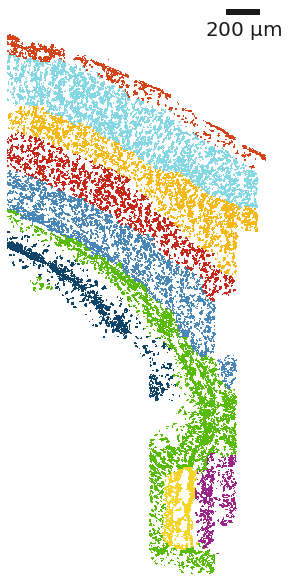

In [139]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[5, 10.5])
cmap = ListedColormap([domain_colors[lbl] for lbl in domain_labels])
ds.plot_domains(rotate=1, cmap=cmap)

scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.axis('off')

In [140]:
analysis.calc_cell_type_compositions()

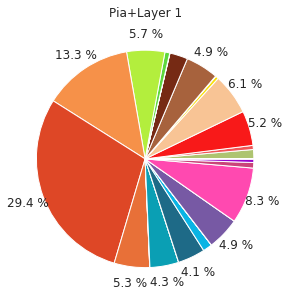

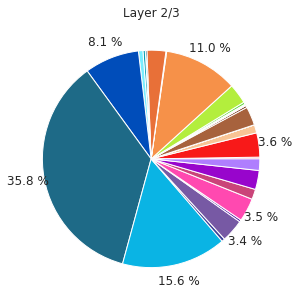

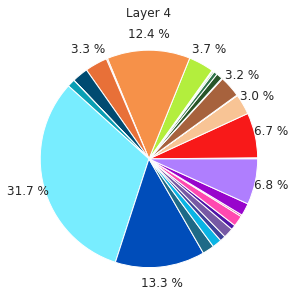

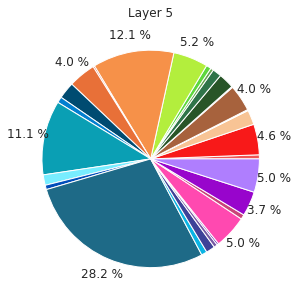

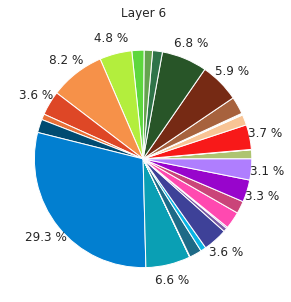

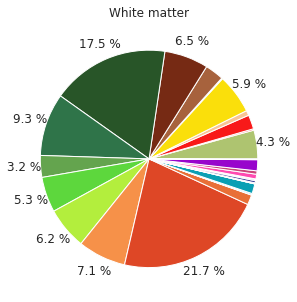

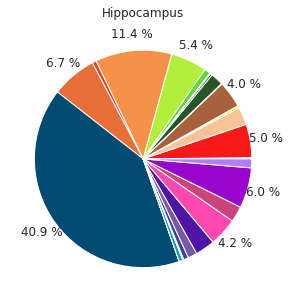

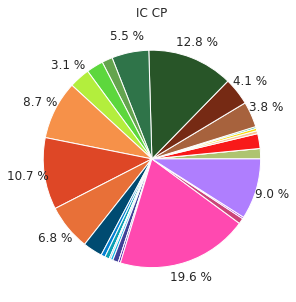

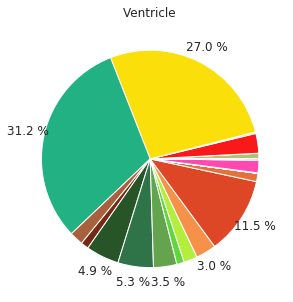

In [144]:
# We updated our algorithm, and below result is slightly
# different from the published one

for domain_idx in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
    plt.figure(figsize=[5, 5])
    ds.plot_celltype_composition(domain_idx,
                                 cell_type_colors=denovo_celltype_colors,
                                 cell_type_orders=heatmap_clusters_index[::-1],
                                 label_cutoff=0.03)
    plt.title(domain_labels[domain_idx])

Text(0.5, 1.0, 'All')

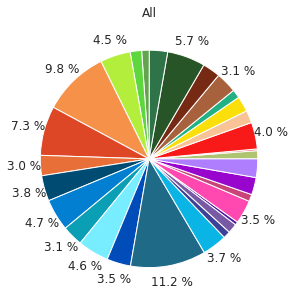

In [145]:
plt.figure(figsize=[5, 5])
ds.plot_celltype_composition(domain_index=9,
                             cell_type_colors=denovo_celltype_colors,
                             cell_type_orders=heatmap_clusters_index[::-1],
                             label_cutoff=0.03)
plt.title('All')

## Reproduce original result in Codeluppi *et al*.

In [146]:
with open("zenodo/osmFISH/raw_data/polyT_seg.pkl", "rb") as f:
    seg_dic = pickle.load(f)

In [147]:
seg_clusternames = list(np.unique(osmfish_loom.col_attrs["ClusterName"]))
col_dic = dict(zip(osmfish_loom.col_attrs['CellID'], [osmfish_ref_colors.get(e, None) for e in osmfish_loom.col_attrs["ClusterName"]]))
clid_dic = dict(zip(osmfish_loom.col_attrs['CellID'], [seg_clusternames.index(e) for e in osmfish_loom.col_attrs["ClusterName"]]))

In [148]:
from matplotlib.colors import to_rgba

seg_img = np.zeros([width_cutoff, ds.shape[1], 4])
seg_img[..., 3] = 1 # background color to black
seg_ctmap = np.zeros([width_cutoff, ds.shape[1]], dtype=int)
for cell_id, seg_coords in seg_dic.items():
    if col_dic[cell_id] is None:
        continue
    seg_coords_small = (seg_coords / pixel_per_um).astype(int)
    seg_col = to_rgba(col_dic[cell_id])
    seg_ctmap[seg_coords_small[:, 0], seg_coords_small[:, 1]] = clid_dic[cell_id]
    seg_img[seg_coords_small[:, 0], seg_coords_small[:, 1]] = seg_col

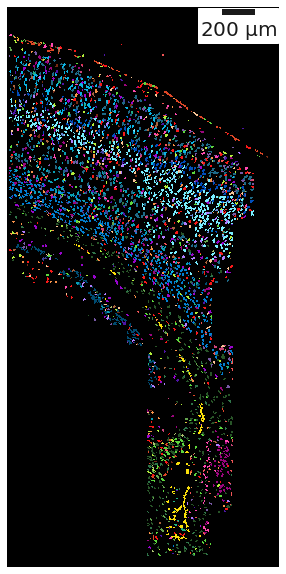

In [149]:
plt.figure(figsize=[5, 10.3])
plt.imshow(seg_img.swapaxes(0, 1))
plt.xlim([width_cutoff, 0])
scalebar = ScaleBar(1, 'um', pad=0.1, font_properties={"size": 20})
plt.gca().add_artist(scalebar)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
sns.despine(top=True, bottom=True, left=True, right=True)
pass

## Gene expression of Mfge8 vs Astrocyte Mfge8

In [150]:
with open('zenodo/osmFISH/raw_data/im_nuc_small.pickle', 'rb') as f:
    dapi = pickle.load(f)
with open('zenodo/osmFISH/raw_data/im_polya_small.pickle', 'rb') as f:
    polya = pickle.load(f)

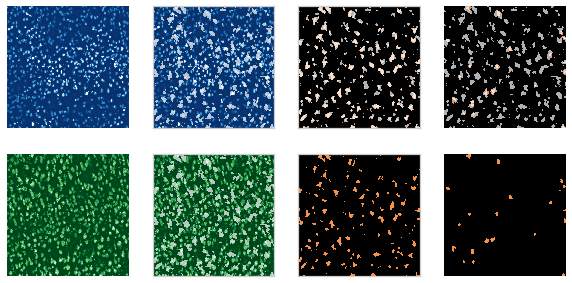

In [152]:
x = slice(1000, 1500)
y = slice(500, 1000)

thres = 0.1

#from skimage.filters import threshold_otsu
gene_exp = ds.vf[x, y, 0, ds.genes.index('Mfge8')].T
#thres = threshold_otsu(gene_exp) - np.std(gene_exp) / 1.5
gene_im = np.zeros([x.stop - x.start, y.stop - y.start, 4])
gene_im[gene_exp > thres] = [1, 1, 1, 0.7]

plt.figure(figsize=[10, 5])
ax = plt.subplot(2, 4, 1)
plt.imshow(dapi[y, x], cmap='Blues_r')
plt.clim([0, 0.004])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(2, 4, 2)
plt.imshow(dapi[y, x], cmap='Blues_r')
plt.clim([0, 0.004])
plt.imshow(gene_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 4, 3)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False, centroid_indices=[
    denovo_labels_final.index("Astrocyte Mfge8"),
])
gene_im2 = np.zeros_like(seg_img)
gene_im2[y, x] = gene_im
plt.imshow(gene_im2)
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 4, 4)
seg_img2 = np.array(seg_img, copy=True)
seg_img2[seg_ctmap != seg_clusternames.index("Astrocyte Mfge8")] = [0, 0, 0, 1]
plt.imshow(seg_img2[x, y].swapaxes(0, 1))
plt.imshow(gene_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(2, 4, 5)
plt.imshow(polya[y, x], cmap='Greens_r')
plt.clim([0, 0.03])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(2, 4, 6)
plt.imshow(polya[y, x], cmap='Greens_r')
plt.clim([0, 0.03])
plt.imshow(gene_im)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


ax = plt.subplot(2, 4, 7)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False, centroid_indices=[
    denovo_labels_final.index("Astrocyte Mfge8"),
])
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2, 4, 8)
seg_img2 = np.array(seg_img, copy=True)
seg_img2[seg_ctmap != seg_clusternames.index("Astrocyte Mfge8")] = [0, 0, 0, 1]
plt.imshow(seg_img2[x, y].swapaxes(0, 1))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

pass

## Ventricle structure

In [ ]:
x = slice(380, 780)
y = slice(2650, 3300)

plt.figure(figsize=[10, 12])
ax = plt.subplot(3, 4, 1)
plt.imshow(dapi[y, x], cmap='Blues_r')
plt.clim([0, 0.004])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 2)
plt.imshow(polya[y, x], cmap='Greens_r')
plt.clim([0, 0.03])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 3)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False)
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 4, 4)
plt.imshow(seg_img.swapaxes(0, 1))
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 5)
plt.imshow(ds.vf[x, y, 0, ds.genes.index('Foxj1')].T, cmap='Reds_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 6)
plt.imshow(ds.vf[x, y, 0, ds.genes.index('Ttr')].T, cmap='Purples_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

ax = plt.subplot(3, 4, 7)
ds.plot_celltypes_map(colors=denovo_celltype_colors, rotate=1, set_alpha=False, centroid_indices=[
    denovo_labels_final.index("Ependymal"),
    denovo_labels_final.index("C. Plexus")
])
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(3, 4, 8)
seg_img2 = np.array(seg_img, copy=True)
seg_img2[np.logical_and(
    seg_ctmap != seg_clusternames.index("Ependymal"),
    seg_ctmap != seg_clusternames.index("C. Plexus"),
)] = [0, 0, 0, 1]
plt.imshow(seg_img2.swapaxes(0, 1))
plt.xlim([x.start, x.stop])
plt.ylim([y.stop, y.start])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')
pass